- Choose a topic in classification (such as: brand classification, cosmetic classification, traditional costumes classification, healthy and unhealthy dishes classification...) => apply CNN to build a model to classify class of each sample.
## Note:
- Create dataset (like dog/cat dataset): with at least 2 classes, each class has at least 2000 training samples, 500 testing samples)

In [1]:
from keras.applications import VGG16, vgg16
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras import regularizers
from keras.applications import EfficientNetB5, efficientnet
from keras.applications import ResNet50, resnet
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/MyDrive/DATA SCIENCE - ĐH KHTN/LDS8 - Deep Learning/FinalTest'
# %cd '/content/gdrive/MyDrive/Deep Learning'

/content/gdrive/MyDrive/DATA SCIENCE - ĐH KHTN/LDS8 - Deep Learning/FinalTest


In [4]:
# !unzip -q '/content/gdrive/MyDrive/DATA SCIENCE - ĐH KHTN/LDS8 - Deep Learning/FinalTest/Data.zip'

# Load image

In [5]:
train_dir = 'Landscape/Training Data'
test_dir = 'Landscape/Testing Data'

In [6]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

In [7]:
# from traitlets.traitlets import validate
# # Image generator for training data and v
# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     zoom_range=0.2,
#     shear_range=0.2,
#     validation_split=0.2,
#     preprocessing_function=preprocess_input
# )

# test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

In [8]:
# New version of TensorFlow (2.10+)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.Rescaling(1./255) # normalize the image
], name="data_augmentation")

In [9]:
seed_train_validation = 1 # Must be same for train_ds and val_ds
shuffle_value = True
validation_split = 0.2

train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       label_mode="binary",
                                                       image_size=IMAGE_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       validation_split=validation_split,
                                                       subset='training',
                                                       shuffle = shuffle_value,
                                                       seed = seed_train_validation)

val_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       label_mode="binary",
                                                       image_size=IMAGE_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       validation_split=validation_split,
                                                       subset='validation',
                                                       shuffle = shuffle_value,
                                                       seed = seed_train_validation)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="binary",
                                                                 image_size=IMAGE_SHAPE,
                                                                 batch_size=BATCH_SIZE)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.
Found 1000 files belonging to 2 classes.


In [10]:
# # Create training and validation generators
# train_generator = train_datagen.flow_from_directory(
#     'Landscape/Training Data',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     subset='training'
# )

# validation_generator = train_datagen.flow_from_directory(
#     'Landscape/Training Data',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     subset='validation'
# )

# test_generator = test_datagen.flow_from_directory(
#     'Landscape/Testing Data',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

#### Note:
* Nguồn data lấy từ https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images/code?datasetId=2707450
* Tuy nhiên không đủ số lượng hình ảnh theo yêu cầu, vì vậy, số lượng data còn thiếu được lấy từ google
* File code cào dữ liệu: Image Scraping.ipynb

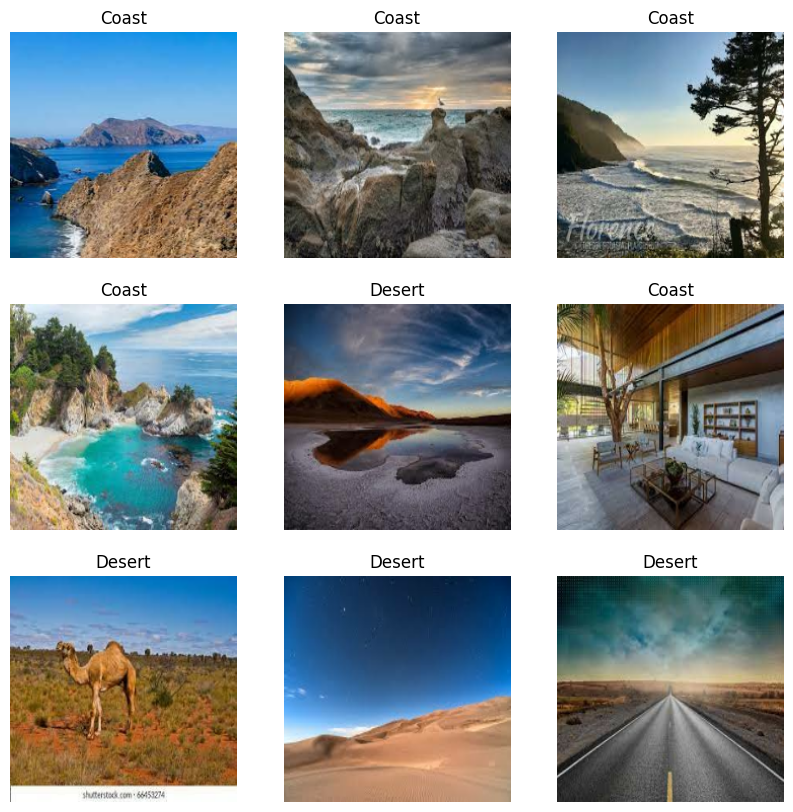

In [11]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    labels = np.array(labels)
    labels = labels.reshape(-1).astype("uint8")
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create a CNN model

In [12]:
img_width, img_height = 224, 224

In [13]:
# Load the VGG model
# include_top=False removes the fully connected layer at the top of the network
model_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [14]:
# View the model summary
model_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# Freeze all the layers
for layer in model_conv.layers:
    layer.trainable = False

In [16]:
# As we only keep the convolutional base, we need to add some more fully connected layers
x = model_conv.output

# Flatten the output layer to 1 dimension
x = Flatten()(x)

x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
# Add a dropout rate of 0.25
x = Dropout(0.2)(x)

# Add a second fully connected layer with 512 hidden units and ReLU activation
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
# Add a dropout rate of 0.25
x = Dropout(0.2)(x)

# Add a second fully connected layer with 512 hidden units and ReLU activation
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
# Add a dropout rate of 0.25
x = Dropout(0.2)(x)

# Add a second fully connected layer with 512 hidden units and ReLU activation
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
# Add a dropout rate of 0.25
x = Dropout(0.2)(x)

# Add a second fully connected layer with 512 hidden units and ReLU activation
x = Dense(8, activation='tanh')(x)
x = BatchNormalization()(x)
# Add a dropout rate of 0.25
# x = Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

In [17]:
# Configure and compile the model
model = Model(inputs=model_conv.input, outputs=x)

In [18]:
# Compile the model
model.compile(Adamax(learning_rate= 0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
# Use model checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'model_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

In [20]:
# Use early stopping to stop training when the validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

In [21]:
# Train the model
start_time = datetime.now()
print(f'Training started at {start_time}')

history = model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    verbose=1,
    callbacks=[checkpoint, early_stopping],
    workers=6 # os.cpu_count() - 1, set number of cores
)

end_time = datetime.now()
print(f'Training ended at {end_time}')

Training started at 2023-06-24 12:21:18.830264
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.5561 - accuracy: 0.7175
Epoch 1: val_loss improved from inf to 0.44000, saving model to model_checkpoints/weights.01-0.44.h5
100/100 [==============================] - 35s 196ms/step - loss: 0.5561 - accuracy: 0.7175 - val_loss: 0.4400 - val_accuracy: 0.8012
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8366
Epoch 2: val_loss improved from 0.44000 to 0.30894, saving model to model_checkpoints/weights.02-0.31.h5
100/100 [==============================] - 20s 194ms/step - loss: 0.3954 - accuracy: 0.8366 - val_loss: 0.3089 - val_accuracy: 0.8750
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.8978
Epoch 3: val_loss improved from 0.30894 to 0.27351, saving model to model_checkpoints/weights.03-0.27.h5
100/100 [==============================] - 19s 190ms/step - loss: 0.2818 - accuracy

In [22]:
print('Time spent:', end_time-start_time)

Time spent: 0:03:15.615049


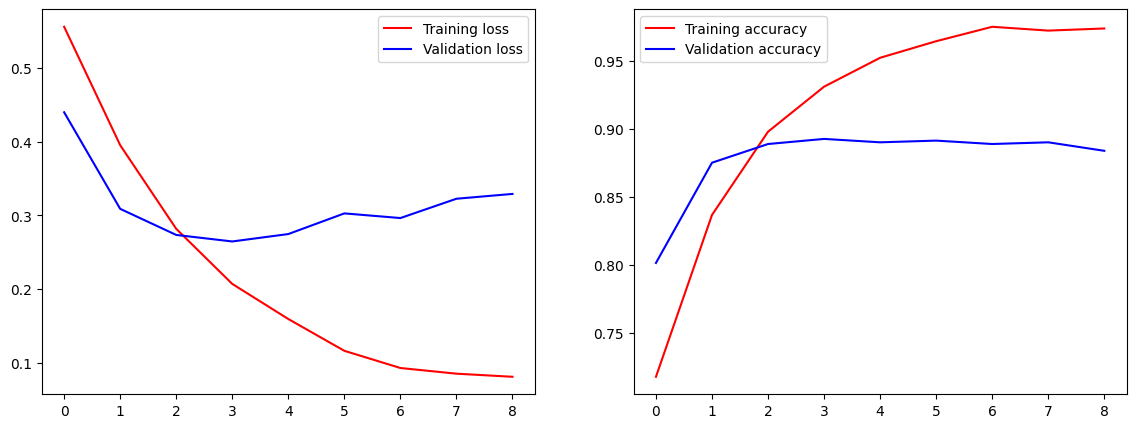

In [23]:
# Draw the loss and accuracy curves of the training set and the validation set
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Draw the loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.legend()

# Draw the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.legend()

plt.show()

In [24]:
loss, accuracy = model.evaluate(test_data)
print('Test accuracy :', accuracy)

32/32 [==============================] - 6s 184ms/step - loss: 0.2897 - accuracy: 0.9010
Test accuracy : 0.9010000228881836


### Confusion matrix of Batch test

In [25]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy()
predictions = predictions.reshape(-1)

label_batch = np.array(label_batch)
label_batch = label_batch.reshape(-1).astype("uint8")

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

Predictions:
 [0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1]
Labels:
 [0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0]


Train report               precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.93      1.00      0.97        14

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32

Train conf matrix [[17  1]
 [ 0 14]]


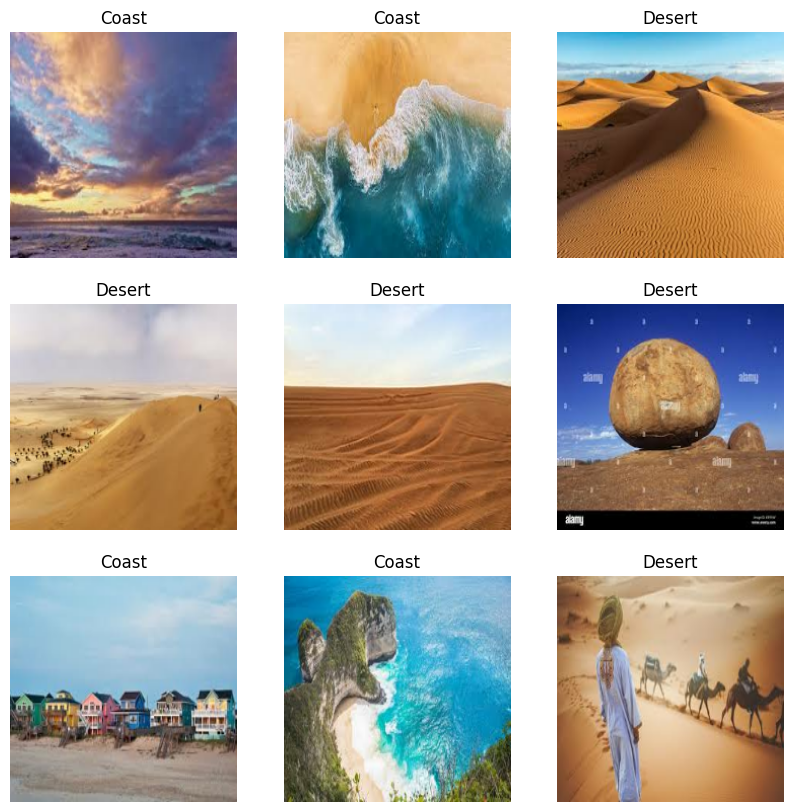

In [26]:
print('Train report', classification_report(label_batch, predictions))
print('Train conf matrix', confusion_matrix(label_batch, predictions))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

### Confusion matrix of test_data

In [27]:
pred_classes = model.predict(test_data)
pred_classes = tf.where(pred_classes < 0.5, 0, 1)
pred_classes = pred_classes.numpy()
pred_classes = pred_classes.reshape(-1)

print(pred_classes[:10])

test_unbatch = test_data.unbatch()
test_labels = []
for (image,label) in test_unbatch:
    test_labels.append(label)

print(test_labels[:10])

print('Train report', classification_report(test_labels, pred_classes))
print('Train conf matrix', confusion_matrix(test_labels, pred_classes))


32/32 [==============================] - 5s 143ms/step
[1 0 0 1 0 1 1 1 1 1]
[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]
Train report               precision    recall  f1-score   support

         0.0       0.51      0.51      0.51       500
         1.0       0.51      0.51      0.51       500

    a

## Nhận xét:
* Mô hình mất khoảng 3 phút để train
* Accuracy của model là ~90% tuy nhiên accuracy sau khi áp dụng confusion matrix tăng lên đến ~97%.
* Accuracy sau khi áp dụng dụ đoán cho tất cả ảnh của tập test chỉ đạt 51%, chênh lệch rất lớn với accuracy của batch.
* Có hiện tượng overfit khi huấn luyện mô hình.
* Loss và accuracy của validation và train khá ổn định trong quá trình huấn luyện.

## So sánh CNN và transfer learning
* Thời gian train mô hình của transfer learning nhỏ hơn rất nhiều so với mô hình CNN đơn thuần.
* Có thể thấy accuracy khi áp dụng transfer learning cao hơn mô hình CNN đơn thuần.
* Cả 2 mô hình đều có hiện tượng overfit, tuy nhiên độ ổn định của transfer learning tốt hơn CNN rất nhiều.